# World Cup Final Project – EDA Notebook

In [1]:
# General
import numpy as np
import pandas as pd
import time

# Plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Coordinates
from geopy.geocoders import Nominatim
from geopy.distance import geodesic, great_circle
geolocator = Nominatim()

# Timezones
import datetime
from datetime import datetime, timedelta
import pytz
from tzwhere import tzwhere
from dateutil import tz
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
tzwhere = tzwhere.tzwhere()

# Data Parsing & Cleaning

In [2]:
# Read data
df_fifa = pd.read_csv('nb1a_match_data.csv')
df_fifa = df_fifa.drop(columns=['Unnamed: 0']);
df_fifa.head()

,date,Home,Home Confed,Away,Away Confed,FT H,FT G,AET H,AET G,AP H,...,PrevDateHome,PrevDateAway,PrevTZHome,PrevTZAway,TimeDeltaHome,TimeDeltaAway,TravelHome,TravelAway,TZDeltaHome,TZDeltaAway
0,10.01.2003,Sri Lanka,AFC,Afghanistan,AFC,1,0,NaN,NaN,NaN,...,<class 'datetime.datetime'>,<class 'datetime.datetime'>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.01.2003,India,AFC,Pakistan,AFC,0,1,NaN,NaN,NaN,...,<class 'datetime.datetime'>,<class 'datetime.datetime'>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.01.2003,Maldives,AFC,Bhutan,AFC,6,0,NaN,NaN,NaN,...,<class 'datetime.datetime'>,<class 'datetime.datetime'>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.01.2003,Bangladesh,AFC,Nepal,AFC,1,0,NaN,NaN,NaN,...,<class 'datetime.datetime'>,<class 'datetime.datetime'>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.01.2003,Barbados,CONCACAF,Jamaica,CONCACAF,1,0,NaN,NaN,NaN,...,<class 'datetime.datetime'>,<class 'datetime.datetime'>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Data Structure
games, columns = df_fifa.shape
print("We have", games, "games in the dataset and", columns, "columns of information.")

print("The Columns names are:\n", df_fifa.columns.values)

We have 14312 games in the dataset and 61 columns of information.
The Columns names are:
 ['date' 'Home' 'Home Confed' 'Away' 'Away Confed' 'FT H' 'FT G' 'AET H'
 'AET G' 'AP H' 'AP G' 'ET' 'PEN' 'Type' 'Town' 'Land' 'neutral venue'
 'HomeAdv' 'Win' 'day' 'month' 'year' 'PrevDiffHome1' 'PrevDiffAway1'
 'PrevDiffHome2' 'PrevDiffAway2' 'PrevDiffHome3' 'PrevDiffAway3'
 'PrevDiffHome4' 'PrevDiffAway4' 'PrevDiffHome5' 'PrevDiffAway5'
 'PrevDiffHome6' 'PrevDiffAway6' 'PrevDiffHome7' 'PrevDiffAway7'
 'PrevDiffHome8' 'PrevDiffAway8' 'PrevDiffHome9' 'PrevDiffAway9'
 'PrevDiffHome10' 'PrevDiffAway10' 'latitude' 'longitude' 'coordinates'
 'dist_home' 'dist_away' 'UTC' 'datetime' 'PrevCordHome' 'PrevCordAway'
 'PrevDateHome' 'PrevDateAway' 'PrevTZHome' 'PrevTZAway' 'TimeDeltaHome'
 'TimeDeltaAway' 'TravelHome' 'TravelAway' 'TZDeltaHome' 'TZDeltaAway']


In [4]:
# Look at Data Types
df_fifa.dtypes

date               object
Home               object
Home Confed        object
Away               object
Away Confed        object
FT H                int64
FT G                int64
AET H             float64
AET G             float64
AP H              float64
AP G              float64
ET                   bool
PEN                  bool
Type               object
Town               object
Land               object
neutral venue      object
HomeAdv             int64
Win               float64
day                 int64
month               int64
year                int64
PrevDiffHome1       int64
PrevDiffAway1       int64
PrevDiffHome2       int64
PrevDiffAway2       int64
PrevDiffHome3       int64
PrevDiffAway3       int64
PrevDiffHome4       int64
PrevDiffAway4       int64
                   ...   
PrevDiffAway5       int64
PrevDiffHome6       int64
PrevDiffAway6       int64
PrevDiffHome7       int64
PrevDiffAway7       int64
PrevDiffHome8       int64
PrevDiffAway8       int64
PrevDiffHome

## Restricting Data to 2006

Justification: Only one player from the 2002 World Cup played in the 2018 World Cup, so the squads that competed in the 2002 World Cup are completely different from those that competed in 2018.
Additionally, FIFA Ranking information is only available from 2006 onward, and since that is one of the inputs we plan on testing for the model, it makes sense for our game data to line up with our FIFA Ranking data.

In [5]:
# Restrict Dataset to 2006+
df_fifa = df_fifa[df_fifa.year > 2005]

games = df_fifa.shape[0]
print("Now we have {} games since {} in the dataset.".format(games, min(df_fifa.year)))

Now we have 11568 games since 2006 in the dataset.


In [6]:
# Re-Index
df_fifa = df_fifa.reset_index()
del df_fifa['index']

In [7]:
df_fifa.head(n=10)

,date,Home,Home Confed,Away,Away Confed,FT H,FT G,AET H,AET G,AP H,...,PrevDateHome,PrevDateAway,PrevTZHome,PrevTZAway,TimeDeltaHome,TimeDeltaAway,TravelHome,TravelAway,TZDeltaHome,TZDeltaAway
0,02.01.2006,Qatar,AFC,Libya,CAF,2,0,NaN,NaN,NaN,...,2005-12-05 00:00:00,2005-12-02 00:00:00,3.0,4.0,28.0,31.0,0.000000,0.000000,0.0,0.000000
1,05.01.2006,Egypt,CAF,Zimbabwe,CAF,2,0,NaN,NaN,NaN,...,2005-12-29 00:00:00,2005-12-31 00:00:00,2.0,2.0,7.0,5.0,25.948812,1085.359653,0.0,0.000000
2,07.01.2006,Togo,CAF,Guinea,CAF,0,1,NaN,NaN,NaN,...,2005-11-13 00:00:00,2005-11-27 00:00:00,3.5,0.0,55.0,41.0,0.000000,0.000000,0.0,0.000000
3,09.01.2006,Morocco,CAF,DR Congo,CAF,3,0,NaN,NaN,NaN,...,2005-11-15 00:00:00,2005-12-14 00:00:00,1.0,2.0,55.0,26.0,0.000000,0.000000,0.0,0.000000
4,11.01.2006,Togo,CAF,Ghana,CAF,1,0,NaN,NaN,NaN,...,2006-01-07 00:00:00,2005-11-14 00:00:00,1.0,3.0,4.0,58.0,403.133862,0.000000,0.0,0.000000
5,12.01.2006,Tunisia,CAF,Libya,CAF,1,0,NaN,NaN,NaN,...,2005-11-16 00:00:00,2006-01-02 00:00:00,2.0,3.0,57.0,10.0,0.000000,410.324175,0.0,-0.200000
6,14.01.2006,Senegal,CAF,DR Congo,CAF,0,0,NaN,NaN,NaN,...,2005-12-29 00:00:00,2006-01-09 00:00:00,2.0,0.0,16.0,5.0,0.000000,478.563671,0.0,0.000000
7,14.01.2006,Morocco,CAF,Zimbabwe,CAF,1,0,NaN,NaN,NaN,...,2006-01-09 00:00:00,2006-01-05 00:00:00,0.0,2.0,5.0,9.0,57.385129,398.254016,0.0,-0.222222
8,14.01.2006,Egypt,CAF,South Africa,CAF,1,2,NaN,NaN,NaN,...,2006-01-05 00:00:00,2005-11-12 00:00:00,2.0,2.0,9.0,63.0,20.182409,0.000000,0.0,0.000000
9,15.01.2006,Tunisia,CAF,Ghana,CAF,2,0,NaN,NaN,NaN,...,2006-01-12 00:00:00,2006-01-11 00:00:00,1.0,1.0,3.0,4.0,0.000000,31.013809,0.0,0.000000


# Exploratory Analysis

In [8]:
df_fifa.describe()

,FT H,FT G,AET H,AET G,AP H,AP G,HomeAdv,Win,day,month,...,dist_away,UTC,PrevTZHome,PrevTZAway,TimeDeltaHome,TimeDeltaAway,TravelHome,TravelAway,TZDeltaHome,TZDeltaAway
count,11568.000000,11568.000000,73.000000,73.000000,196.000000,196.000000,11568.000000,11182.000000,11568.000000,11568.000000,...,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000
mean,1.551694,1.054115,1.616438,1.410959,3.923469,3.887755,0.706172,0.600072,14.324775,6.950121,...,3301.359195,1.681017,1.721127,1.634595,40.046680,42.774550,131.164526,190.752895,0.003067,0.010732
std,1.534849,1.234645,1.231870,1.065046,1.715468,1.785311,0.473768,0.422938,8.534668,3.247948,...,3114.066645,3.849988,3.831769,3.874117,85.464733,89.212889,332.347698,448.760746,0.208029,0.288983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,1.000000,...,0.000000,-11.000000,-11.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,-2.500000,-3.000000
25%,0.000000,0.000000,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,7.000000,5.000000,...,1196.571370,0.000000,1.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,0.500000,13.000000,7.000000,...,2242.327328,2.000000,2.000000,2.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,1.000000,1.000000,22.000000,10.000000,...,4350.340158,3.000000,3.000000,3.000000,52.000000,52.000000,71.448350,214.670394,0.000000,0.000000
max,17.000000,15.000000,7.000000,4.000000,11.000000,12.000000,1.000000,1.000000,31.000000,12.000000,...,19604.328611,13.000000,13.000000,13.000000,2917.000000,1444.000000,7444.818493,15112.446277,4.500000,10.000000


All distances and time deltas are positive, so a visual inspection checks out. The main issue is that there are default values of 100 instead of NA in the "Previous Goal Difference" Columns, so we need to clean that up, but we have dealt with that in one of the more recent notebooks.

## Game Types and Results

In [9]:
# Look at Unique Game Types
df_fifa.Type.unique()

array(['FSS', 'Cont', 'ContQ', 'WM', 'WM-Q', 'KFC'], dtype=object)

The dataset includes categories for Friendly games, Continental Qualifiers, World Cup Qualifiers, Continental Tournaments, World Cup Tournaments, and Confederation Tournaments.

In [10]:
# Print Breakdown of Game Types
friendly = np.mean(df_fifa['Type'] == 'FSS')
cont = np.mean(df_fifa['Type'] == 'Cont')
world = np.mean(df_fifa['Type'] == 'WM')
tournament = cont + world + np.mean(df_fifa['Type'] == 'KFC')
qual_c = np.mean(df_fifa['Type'] == 'ContQ')
qual_w = np.mean(df_fifa['Type'] == 'WM-Q')
qualifier = qual_c + qual_w
official = qualifier + tournament
russia = np.mean((df_fifa['Type'] == 'WM') & (df_fifa.year == 2018))

print("Friendly Games: {0:.1%}".format(friendly))
print("Continental Qualifier Games: {0:.1%}".format(qual_c))
print("World Cup Qualifier Games: {0:.1%}".format(qual_w))
print("All Qualifiers: {0:.1%}".format(qualifier))
print("Continental Tournament: {0:.1%}".format(cont))
print("World Cup Tournament: {0:.1%}".format(world))
print("All Tournaments: {0:.1%}".format(tournament))
print("All Official (Qual + Tourn): {0:.1%}".format(official))
print("2018 World Cup: {0:.1%}".format(russia))

Friendly Games: 52.3%
Continental Qualifier Games: 17.2%
World Cup Qualifier Games: 21.9%
All Qualifiers: 39.1%
Continental Tournament: 6.0%
World Cup Tournament: 2.2%
All Tournaments: 8.7%
All Official (Qual + Tourn): 47.7%
2018 World Cup: 0.6%


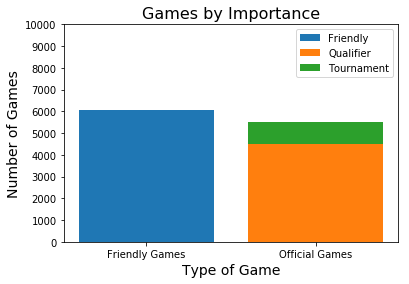

In [11]:
# Plot Breakdown of Game Types

# Calculate Number of Games
friendly = np.sum(df_fifa['Type'] == 'FSS')
cont = np.sum(df_fifa['Type'] == 'Cont')
world = np.sum(df_fifa['Type'] == 'WM')
tournament = cont + world + np.sum(df_fifa['Type'] == 'KFC')
qual_c = np.sum(df_fifa['Type'] == 'ContQ')
qual_w = np.sum(df_fifa['Type'] == 'WM-Q')
qualifier = qual_c + qual_w
official = qualifier + tournament

# Plot
N = 2
friendlies = (friendly, 0)
qualifiers = (0, qualifier)
tournaments = (0, tournament)
worlds = (0, world)

ind = np.arange(N)    # the x locations for the groups

p1 = plt.bar(ind, friendlies)
p2 = plt.bar(ind, qualifiers,
             bottom=friendlies)
p3 = plt.bar(ind, tournaments,
             bottom=qualifiers)

# Label
plt.ylabel('Number of Games', fontsize=14)
plt.xlabel('Type of Game', fontsize=14)
plt.title('Games by Importance', fontsize=16)
plt.xticks(ind, ('Friendly Games', 'Official Games'))
plt.yticks(np.arange(0, 11000, 1000))
plt.legend((p1[0], p2[0], p3[0]), ('Friendly', 'Qualifier', 'Tournament'))

plt.savefig('Breakdown.png')

plt.show()

If we want to predict only on World Cup games, then we're looking at exactly 2.2% of the dataset. 2018 World Cup games comprise only 0.6% of the games included, so we might want to expand our scope for a "test" set, or even think about using a random subset of all tournament games as a validation set.

72.3% of games include a team playing at home.
27.7% of games are played on neutral ground.


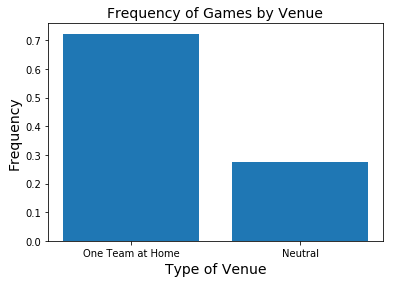

In [12]:
# Hosting Type

# Calculate
neutral = np.mean(df_fifa.HomeAdv == 0)
home = np.mean(df_fifa.HomeAdv != 0)

# Print
print("{0:.1%} of games include a team playing at home.".format(home))
print("{0:.1%} of games are played on neutral ground.".format(neutral))

# Plot
plt.bar(['One Team at Home', 'Neutral'], [home, neutral])
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Type of Venue', fontsize=14)
plt.title('Frequency of Games by Venue', fontsize=14)
plt.show()

This is important to know since there exists a well-documented home advantage in soccer, and a good model should probably incorporate that information.

In [13]:
# Result Frequency in Neutral Venues

# Subset DataFrame
df_neutral = df_fifa[df_fifa.HomeAdv == 0]

# Calculate
draws = np.mean((df_neutral['FT H'] - df_neutral['FT G']) == 0)
overtime = np.mean(df_neutral['ET'])

# Print
print("Around {0:.1%} of games played on neutral ground end in draws after 90 minutes.".format(draws))
print("Only {0:.1%} of all games played on neutral ground go into overtime.".format(overtime))

Around 27.0% of games played on neutral ground end in draws after 90 minutes.
Only 1.3% of all games played on neutral ground go into overtime.


50.1% of games end in a win for the home team after 90 minutes.
23.6% of games played where one team has home advantage ground end in draws after 90 minutes.
26.2% of games end in a loss for the home team after 90 minutes.


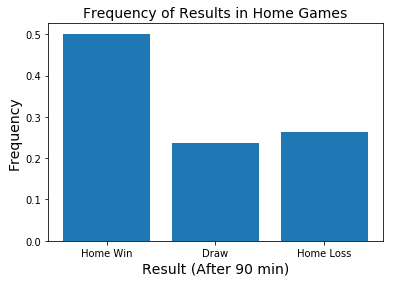

In [14]:
# Results when one team is at home

# Subset DataFrame
df_home = df_fifa[df_fifa.HomeAdv != 0]

# Calculate
draws = np.mean((df_home['FT H'] - df_home['FT G']) == 0)
home_win = np.mean((df_home['FT H'] > df_home['FT G']))
home_loss = np.mean((df_home['FT H'] < df_home['FT G']))

# Print
print("{0:.1%} of games end in a win for the home team after 90 minutes.".format(home_win))
print("{0:.1%} of games played where one team has home advantage ground end in draws after 90 minutes.".format(draws))
print("{0:.1%} of games end in a loss for the home team after 90 minutes.".format(home_loss))

# Plot
plt.bar(['Home Win', 'Draw', 'Home Loss'], [home_win, draws, home_loss])
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Result (After 90 min)', fontsize=14)
plt.title('Frequency of Results in Home Games', fontsize=14)
plt.show()

41.0% of games end in a win for the Team A after 90 minutes.
27.0% of games played where no team has home advantage ground end in draws after 90 minutes.
32.0% of games end in a loss for Team A after 90 minutes.


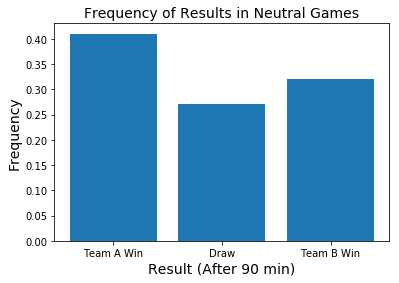

In [15]:
# Results when one team is at home

# Subset DataFrame
df_home = df_fifa[df_fifa.HomeAdv == 0]

# Calculate
draws = np.mean((df_home['FT H'] - df_home['FT G']) == 0)
home_win = np.mean((df_home['FT H'] > df_home['FT G']))
home_loss = np.mean((df_home['FT H'] < df_home['FT G']))

# Print
print("{0:.1%} of games end in a win for the Team A after 90 minutes.".format(home_win))
print("{0:.1%} of games played where no team has home advantage ground end in draws after 90 minutes.".format(draws))
print("{0:.1%} of games end in a loss for Team A after 90 minutes.".format(home_loss))

# Plot
plt.bar(['Team A Win', 'Draw', 'Team B Win'], [home_win, draws, home_loss])
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Result (After 90 min)', fontsize=14)
plt.title('Frequency of Results in Neutral Games', fontsize=14)
plt.savefig('Results.png')
plt.show()

83.5% of games occur between teams from the same Confederation.
16.5% of games occur between teams from different Confederations.


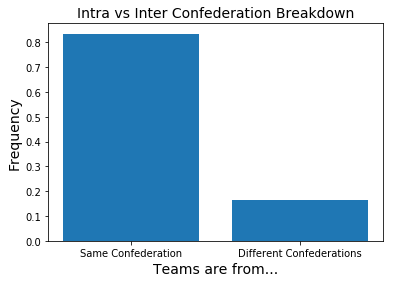

In [16]:
# Within v Across Federations

# Calculate
intra_confed = np.mean(df_fifa['Home Confed'] == df_fifa['Away Confed'])
inter_confed = np.mean(df_fifa['Home Confed'] != df_fifa['Away Confed'])

# Print
print("{0:.1%} of games occur between teams from the same Confederation.".format(intra_confed))
print("{0:.1%} of games occur between teams from different Confederations.".format(inter_confed))

# Plot
plt.bar(['Same Confederation', 'Different Confederations'], [intra_confed, inter_confed])
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Teams are from...', fontsize=14)
plt.title('Intra vs Inter Confederation Breakdown', fontsize=14)
plt.show()

# Location and Team Information

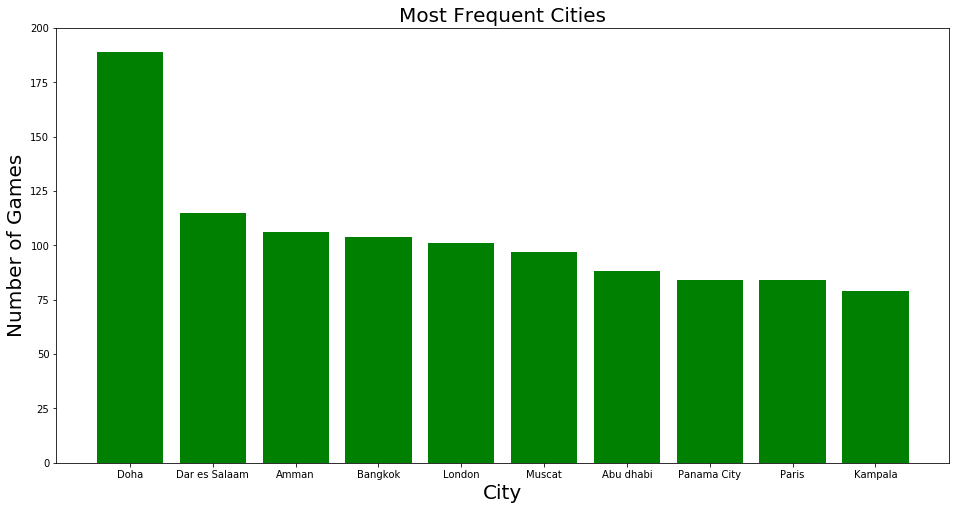

In [17]:
# Most Frequent Cities
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

city_count = df_fifa.Town.value_counts()[0:10]
cities = city_count.index
N = 10
ind = np.arange(N)    # the x locations for the groups

ax.bar(ind, city_count, color='g')
plt.ylabel('Number of Games', fontsize=20)
plt.xlabel('City', fontsize=20)
plt.title('Most Frequent Cities', fontsize=20)
plt.yticks(np.arange(0, 225, 25))
plt.xticks(ind, cities)
plt.savefig('HostCities.png')
plt.show()

As Qatar gears up to host the 2022 World Cup, it seems like Doha is going all in on hosting international soccer matches.

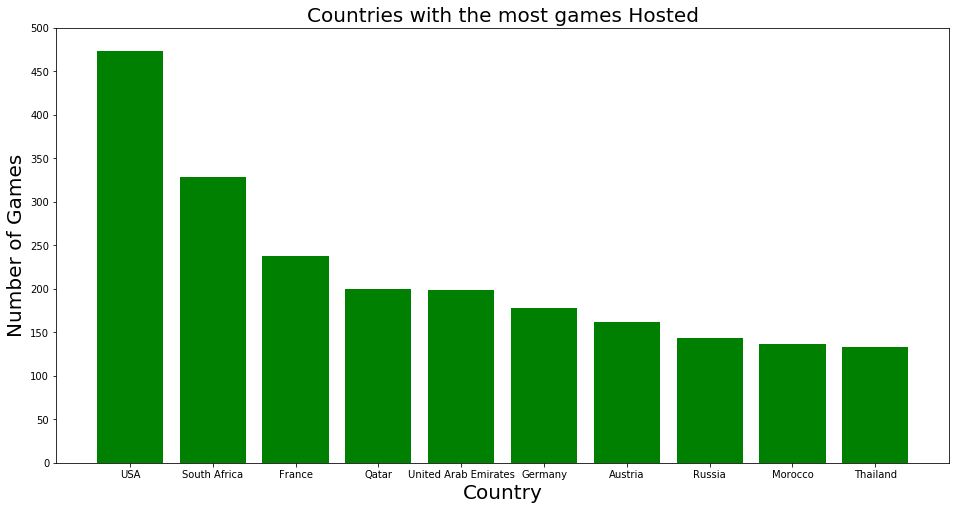

In [18]:
# Most Frequent Countries (Host)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

country_count = df_fifa.Land.value_counts()[0:10]
countries = country_count.index

N = 10
ind = np.arange(N)    # the x locations for the groups

ax.bar(ind, country_count, color='g')
plt.ylabel('Number of Games', fontsize=20)
plt.xlabel('Country', fontsize=20)
plt.title('Countries with the most games Hosted', fontsize=20)
plt.yticks(np.arange(0, 550, 50))
plt.xticks(ind, countries)
plt.savefig('Hosts.png')
plt.show()

------
Six of the top eight countries have either hosted or been selected to host a major tournament:

USA – Gold Cup, Copa America 2016

South Africa – World Cup 2010

France – Euro Cup 2016

Qatar – World Cup 2022

Germany – World Cup 2006

Russia – World Cup 2018

------

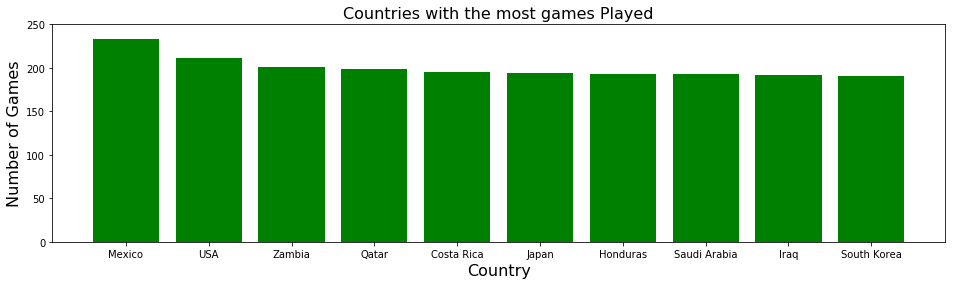

In [19]:
# Most Frequent Countries (Play)
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)

team_count = (df_fifa.Home.value_counts() + df_fifa.Away.value_counts()).sort_values(ascending=False)
team_count = team_count[0:10]
teams = team_count.index

N = 10
ind = np.arange(N)    # the x locations for the groups

ax.bar(ind, team_count, color='g')
plt.ylabel('Number of Games', fontsize=16)
plt.xlabel('Country', fontsize=16)
plt.title('Countries with the most games Played', fontsize=16)
plt.yticks(np.arange(0, 300, 50))
plt.xticks(ind, teams)
plt.show()

Countries in the top 10 are primarily from Concacaf (North America) and AFC (Asia).

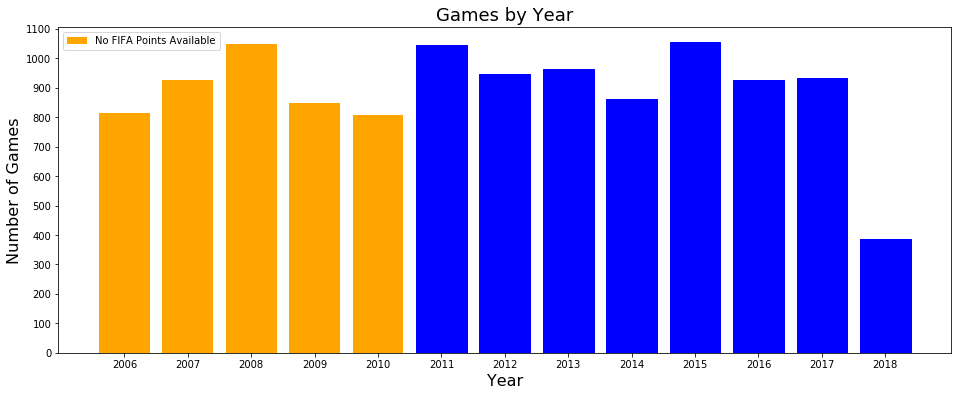

In [20]:
# Games by Year
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

# Count Games
year_count = []
for year in range(2006, 2019):
    year_count.append(np.sum(df_fifa.year == year))

N = len(year_count)
ind = np.arange(N) 

barlist = ax.bar(ind, year_count, color='orange', label='No FIFA Points Available')

for i in range(5,13):
    barlist[i].set_color('blue')

plt.ylabel('Number of Games', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Games by Year', fontsize=18)
plt.yticks(np.arange(0, 1200, 100))
plt.xticks(ind, range(2006, 2019))
plt.legend(loc=2)
plt.savefig('Games.png')
plt.show()

The number of games per year hovers close to 900 on average. 2018 obviously has less games since there are still 5 months to go.

# WIGGO Rankings

In [21]:
# Read data
df_wiggo = pd.read_csv('nb1b_wiggo_rankings.csv')
df_wiggo = df_wiggo.drop(columns=['Unnamed: 0']);
df_wiggo.columns = ['Date', 'Rank', 'Rating', 'Team']
df_wiggo.replace('Lithania', 'Lithuania', inplace=True);
df_wiggo.replace('FYR of Macedonia', 'Macedonia', inplace=True);

In [22]:
print("The Columns names are:\n", df_wiggo.columns.values)
df_wiggo.head()

The Columns names are:
 ['Date' 'Rank' 'Rating' 'Team']


,Date,Rank,Rating,Team
0,2006-01-01,1.0,1849.209290,Brazil
1,2006-01-01,2.0,1829.055748,Czech Republic
2,2006-01-01,3.0,1826.724124,Netherlands
3,2006-01-01,4.0,1823.625499,France
4,2006-01-01,5.0,1806.653651,England


In [23]:
fifa_teams = df_wiggo.Team.unique()
fifa_teams = fifa_teams.astype(str)
fifa_teams = [fifa_teams for fifa_teams in fifa_teams if str(fifa_teams) != 'nan']
fifa_teams.sort()
print("There are {} teams in the WIGGO set.".format(len(fifa_teams)))

There are 211 teams in the WIGGO set.


This number lines up exactly with the number of FIFA Members.

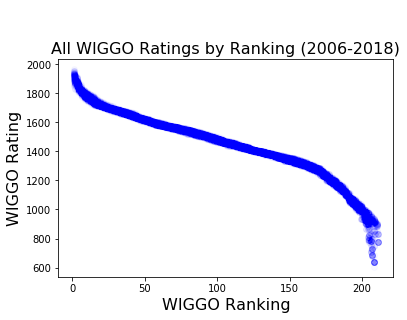

In [24]:
# Plot WIGGO Ratings vs Rankings
plt.plot(df_wiggo.Rank, df_wiggo.Rating, 'bo', alpha=.01)

# Label
plt.title('\n\nAll WIGGO Ratings by Ranking (2006-2018)', fontsize=16)
plt.xlabel('WIGGO Ranking', fontsize=16)
plt.ylabel('WIGGO Rating', fontsize=16)

plt.savefig('WIGGO.png')
plt.show()

The distribution of WIGGO rankings appears as though it follows a very well-defined function (perhaps a cubic one) with a random distribution around the main function.

In [25]:
# Subset Data by Rank for Visualization
wiggo_1st = df_wiggo[df_wiggo.Rank == 1]
wiggo_3rd = df_wiggo[df_wiggo.Rank == 3]
wiggo_5th = df_wiggo[df_wiggo.Rank == 5]
wiggo_10th = df_wiggo[df_wiggo.Rank == 10]

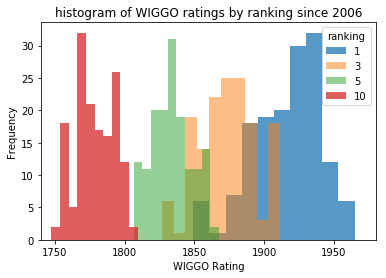

In [26]:
# Plot Histogram
plt.hist(wiggo_1st.Rating, alpha = 0.75, histtype='stepfilled', edgecolor='none')
plt.hist(wiggo_3rd.Rating, alpha = 0.5, histtype='stepfilled', edgecolor='none')
plt.hist(wiggo_5th.Rating, alpha = 0.5, histtype='stepfilled', edgecolor='none')
plt.hist(wiggo_10th.Rating, alpha = 0.75, histtype='stepfilled', edgecolor='none')

# Add Labels
plt.title('histogram of WIGGO ratings by ranking since 2006')
plt.xlabel('WIGGO Rating')
plt.ylabel('Frequency')
plt.xlim(1740, 1980)
labels= ["1", "3", "5", "10"]
plt.legend(labels, title='ranking')

plt.savefig('WIGGO2.png')

# Show
plt.show()

It seems as though the histograms of WIGGO ratings are fairly normally distributed for each ranking, and that there is little to no overlap in rating distributions for rankings that are five places apart.

# Geographic Visualizations

In [27]:
locations = pd.read_csv('GameCoordinates.csv')
del locations['Unnamed: 0']
locations.head()

,Town,Land,count,lat,lon,coordinates
0,6th October City,Egypt,3,29.972346,30.940921,"(29.9723458, 30.9409205)"
1,Aachen,Germany,1,50.776351,6.083862,"(50.776351, 6.083862)"
2,Aalborg,Denmark,3,57.048221,9.919394,"(57.0482206, 9.9193939)"
3,Aarhus,Denmark,7,56.149628,10.213405,"(56.1496278, 10.2134046)"
4,Abeokuta,Nigeria,1,7.161000,3.348000,"(7.161, 3.348)"


# Home Field Location

In [28]:
home_hq = pd.read_csv('HomeFieldCoordinates.csv')
del home_hq['Unnamed: 0']
home_hq.head()

,Home,Town,count,lat,lon,coordinates
0,Afghanistan,Kabul,2,34.526013,69.177648,"(34.5260131, 69.1776476)"
1,Albania,Tirana,48,41.327946,19.818532,"(41.3279457, 19.8185323)"
2,Algeria,Blida,33,36.470165,2.828798,"(36.4701645, 2.8287985)"
3,Andorra,Andorra la Vella,44,42.506939,1.521247,"(42.5069391, 1.5212467)"
4,Angola,Luanda,44,-8.827270,13.243951,"(-8.8272699, 13.2439512)"


## Distance from Home

In [29]:
# Calculate Average Distance from Home
teams = []
dist_from_home = []

for team in df_fifa.Home.unique():
    teams.append(team)
    
    dist = np.sum(df_fifa.dist_home[df_fifa.Home == team]) + np.sum(df_fifa.dist_away[df_fifa.Away == team])
    games = np.sum((df_fifa.Home == team) | (df_fifa.Away == team))
    
    dist_from_home.append(dist/games)

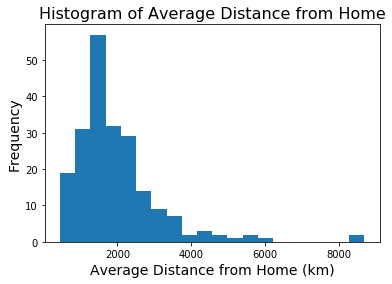

In [30]:
# Plot Average Distance from Home
plt.hist(dist_from_home, bins=20)

# Label
plt.title('Histogram of Average Distance from Home', fontsize=16)
plt.xlabel('Average Distance from Home (km)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.savefig('Distance.png')

plt.show()

In [31]:
# See which teams have the toughest travel schedule 
for i in range(len(teams)):
    if dist_from_home[i] > 8000:
        print(teams[i])
        
# Makes sense that Australia and New Zealand play far away from home

New Zealand
Australia


In [32]:
# See which teams have the lightest travel schedule
for i in range(len(teams)):
    if dist_from_home[i] < 500:
        print(teams[i])
        
# Austria is located centrally in Europe, so any European game is relatively close
# The 3 island nations probably only play either at home or in their region

Austria
St. Vincent and the Grenadines
British Virgin Islands
US Virgin Islands


# Time Zones

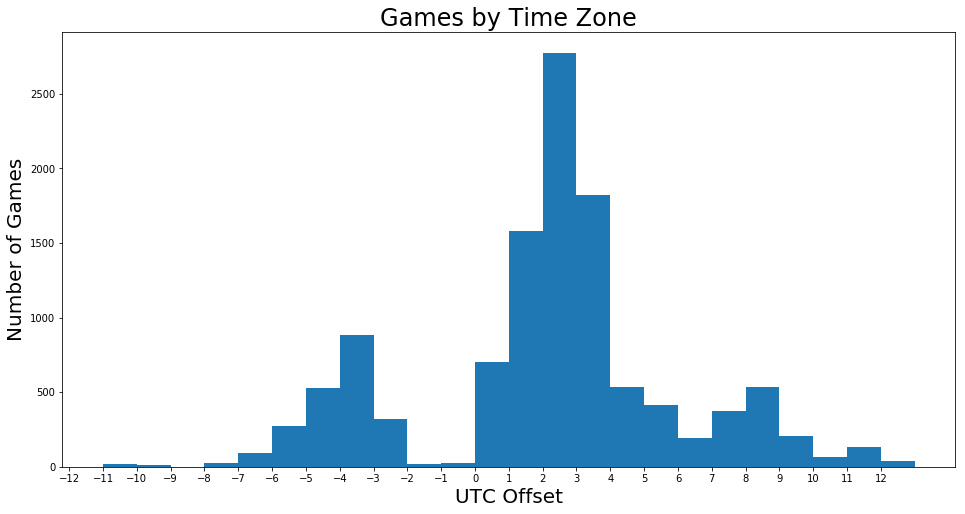

In [33]:
# Plot Games by Time Zone
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist(df_fifa.UTC, bins=24)

# Label
plt.title('Games by Time Zone', fontsize=24)
plt.ylabel('Number of Games', fontsize=20)
plt.xlabel('UTC Offset', fontsize=20)
plt.xticks(range(-12,13))

plt.savefig('TimeZones.png')

plt.show()

We see that the majority of games are played in European timezones, and then there are also a decent amount of games in the Americas and Asia. This histogram is a good check on our UTC Offset function, as it looks exactly what we would expect it to look like. The reason for including information on timezones is that there has been extensive research on US sports showing that the direction teams travel in, and thus whether they move ahead or behind in timezone, affects their performance. We want to see if there is a similar effect in soccer.

# Fatigue Metrics

In [34]:
# Look at all our metrics
df_fifa.describe()

,FT H,FT G,AET H,AET G,AP H,AP G,HomeAdv,Win,day,month,...,dist_away,UTC,PrevTZHome,PrevTZAway,TimeDeltaHome,TimeDeltaAway,TravelHome,TravelAway,TZDeltaHome,TZDeltaAway
count,11568.000000,11568.000000,73.000000,73.000000,196.000000,196.000000,11568.000000,11182.000000,11568.000000,11568.000000,...,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000
mean,1.551694,1.054115,1.616438,1.410959,3.923469,3.887755,0.706172,0.600072,14.324775,6.950121,...,3301.359195,1.681017,1.721127,1.634595,40.046680,42.774550,131.164526,190.752895,0.003067,0.010732
std,1.534849,1.234645,1.231870,1.065046,1.715468,1.785311,0.473768,0.422938,8.534668,3.247948,...,3114.066645,3.849988,3.831769,3.874117,85.464733,89.212889,332.347698,448.760746,0.208029,0.288983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,1.000000,...,0.000000,-11.000000,-11.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,-2.500000,-3.000000
25%,0.000000,0.000000,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,7.000000,5.000000,...,1196.571370,0.000000,1.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,0.500000,13.000000,7.000000,...,2242.327328,2.000000,2.000000,2.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,1.000000,1.000000,22.000000,10.000000,...,4350.340158,3.000000,3.000000,3.000000,52.000000,52.000000,71.448350,214.670394,0.000000,0.000000
max,17.000000,15.000000,7.000000,4.000000,11.000000,12.000000,1.000000,1.000000,31.000000,12.000000,...,19604.328611,13.000000,13.000000,13.000000,2917.000000,1444.000000,7444.818493,15112.446277,4.500000,10.000000


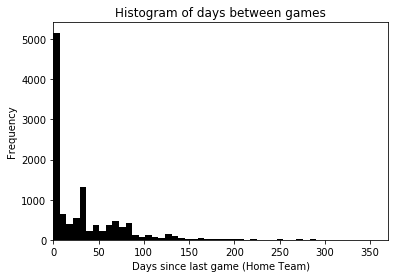

In [35]:
# Visualize Time between Games
plt.hist(df_fifa.TimeDeltaHome[df_fifa.TimeDeltaHome < 365], bins=50, color='black')

# Label
plt.title('Histogram of days between games')
plt.xlabel('Days since last game (Home Team)')
plt.ylabel('Frequency')
plt.xlim(0, 370)

plt.savefig('TimeDelta.png')

plt.show()

We can see that the vast majority of games occur in close succession.

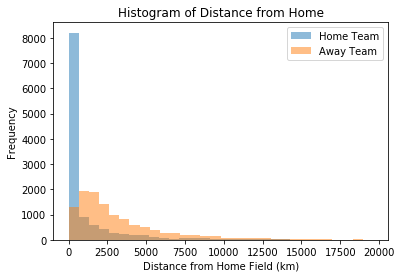

In [36]:
# Visualize Distance from Home
plt.hist(df_fifa.dist_home, alpha=.5, label='Home Team', bins=30)
plt.hist(df_fifa.dist_away, alpha=.5, label='Away Team', bins=30)

# Label
plt.title('Histogram of Distance from Home')
plt.xlabel('Distance from Home Field (km)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('DistanceCompare.png')
plt.show()

We can see that the distribution for distance from home is different between home teams and away teams. Away teams have to travel further, on average, than the team that is logged at home (which is not always the host country).

In [37]:
# Find furthest distance traveled
for i in df_fifa.index:
    if df_fifa.dist_away[i] == max(df_fifa.dist_away):
        print('{} vs {} in {}, {}. {} was {} km from home.'.format(df_fifa.Away[i],
                                         df_fifa.Home[i],
                                         df_fifa.Town[i],
                                         df_fifa.Land[i],
                                         df_fifa.Away[i],
                                         round(df_fifa.dist_away[i], 0)))

Uruguay vs South Korea in Goyang, South Korea. Uruguay was 19604.0 km from home.
